In [6]:
import keras
import os
import cv2
import scipy
import numpy as np
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Model
from keras import optimizers

In [2]:
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [10]:
# What data should we load?
# What to do with unlabeled data?
def get_data(folder):
    X, y, z = [], [], []
    wbc_types = {'NEUTROPHIL': (0,1), 'EOSINOPHIL': (1,1), 'MONOCYTE': (2,0), 'LYMPHOCYTE': (3,0)}
    for (wbc_type, labels) in wbc_types.items():  
        for image_filename in tqdm(os.listdir(folder + wbc_type)):
            img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
            if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(labels[0])
                    z.append(labels[1])
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

from keras.utils.np_utils import to_categorical

X_train, y_train, z_train = get_data("blood-cells/dataset2-master/images/TRAIN/")
X_test, y_test, z_test = get_data("blood-cells/dataset2-master/images/TEST/")
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

  0%|          | 0/2499 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 620/620 [00:01<00:00, 412.94it/s]


In [37]:
def plot_images(imgs, labels=None, rows=1, figsize=(20,8), fontsize=14):
    figure = plt.figure(figsize=figsize)
    cols = max(1,len(imgs) // rows-1)
    labels_present = False
    # checking if labels is a numpy array
    if type(labels).__module__ == np.__name__:
        labels_present=labels.any()
    elif labels:
        labels_present=True
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols+1, i+1)
        # axis off, but leave a bounding box
        plt.tick_params(
            axis='both',
            which='both',
            bottom='off',
            top='off',
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
        # plot labels if present
        if labels_present:
            subplot.set_title(labels[i], fontsize=fontsize)
        plt.imshow(imgs[i])
        
    plt.show()

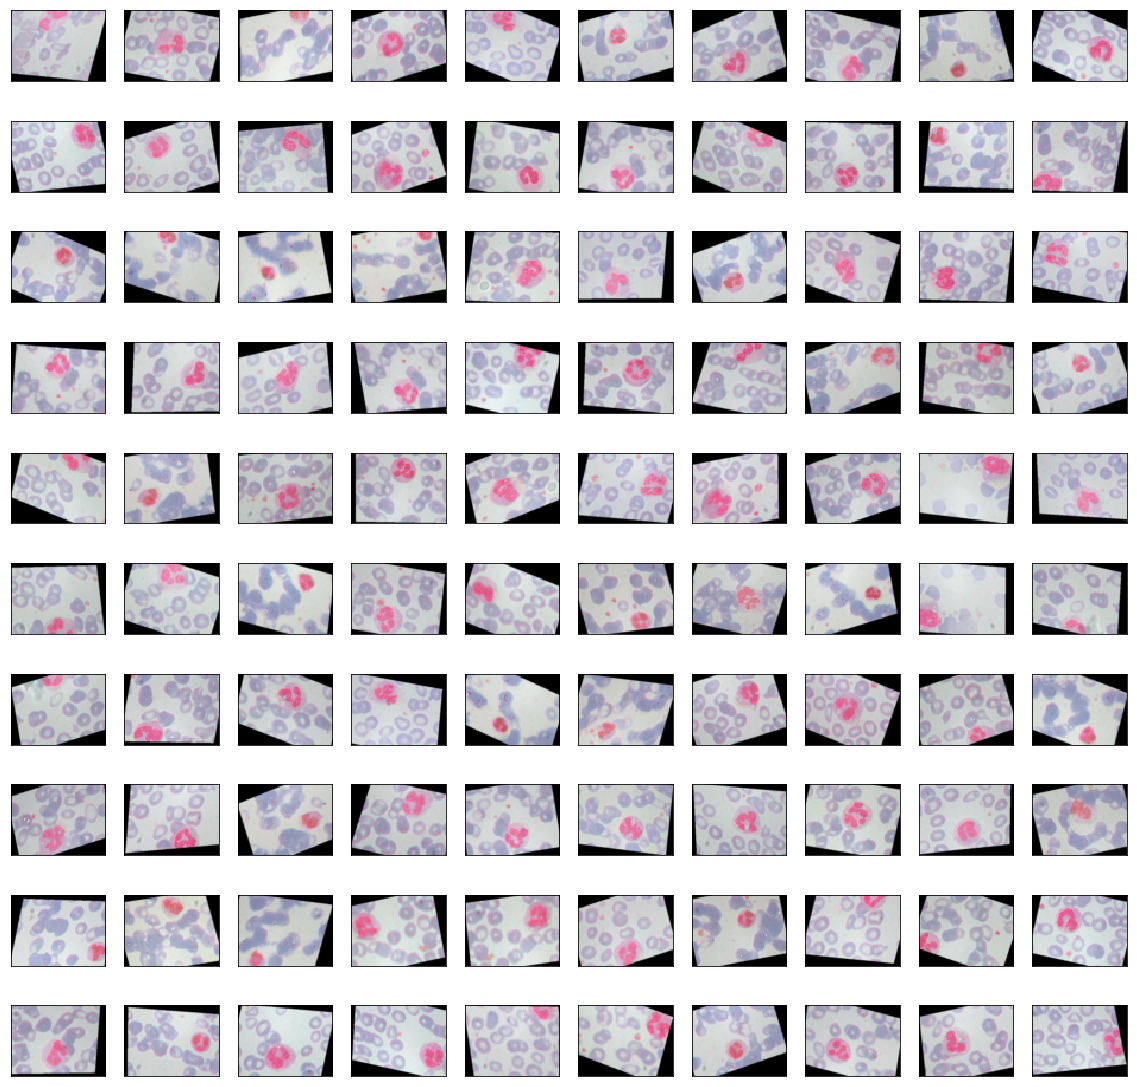

In [38]:
# data visualization etc.
from matplotlib import pyplot as plt

plot_images(X_train[0:100], rows=10, figsize=(20,20))

# mean image
# std image
# count plot
# covariance matrix
# svd of covariance matrix
# show a few examples of what the data looks like

# preprocessing?

In [41]:
# swish vs relu vs other stuff? maybe softmax?
# more normalization?
# more fully connected layers?
# more Conv layers?
# more dropout layers?
# other types of regularizaton? Dropconnect? Bayes by backprop? L1/L2?
# other normalization techniques?
# other optimizers? change learning rate as we go?
# more complicated network structures? bounding box?
def build_model(*args, **kwargs):
    inp = Input(shape=(60,80,3))
    x = BatchNormalization()(inp)
    x = Conv2D(32, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), padding="same", strides=(2,2))(x)
    x = Conv2D(32, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), padding="same", strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(4, activation='softmax')(x)
    
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01, decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 80, 3)         12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 40, 4)         304       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 20, 4)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 10, 4)          404       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 5, 4)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 80)                0         
__________

In [42]:
# train model
h = model.fit(X_train, y_trainHot, epochs=80, batch_size=32, validation_data=(X_test, y_testHot), verbose=1)

# save model
# better validation set (do not use test set)

Train on 9957 samples, validate on 2487 samples
Epoch 1/80
9957/9957 [==============================] - 20s 2ms/step - loss: 1.4064 - acc: 0.2943 - val_loss: 1.3742 - val_acc: 0.3084
Epoch 2/80
9957/9957 [==============================] - 18s 2ms/step - loss: 1.2988 - acc: 0.3669 - val_loss: 1.3293 - val_acc: 0.3084
Epoch 3/80
9957/9957 [==============================] - 18s 2ms/step - loss: 1.1989 - acc: 0.4488 - val_loss: 1.2437 - val_acc: 0.3965
Epoch 4/80
9957/9957 [==============================] - 18s 2ms/step - loss: 1.1271 - acc: 0.4939 - val_loss: 1.1844 - val_acc: 0.4133
Epoch 5/80
9957/9957 [==============================] - 19s 2ms/step - loss: 1.0484 - acc: 0.5423 - val_loss: 1.0586 - val_acc: 0.4942
Epoch 6/80
9957/9957 [==============================] - 19s 2ms/step - loss: 0.9475 - acc: 0.5871 - val_loss: 0.9322 - val_acc: 0.5774
Epoch 7/80
9957/9957 [==============================] - 19s 2ms/step - loss: 0.8521 - acc: 0.6289 - val_loss: 0.9205 - val_acc: 0.5746
Epoch 8

KeyboardInterrupt: 

In [21]:
# test model (on completely unseen data)
model.evaluate(X_test, y_testHot, batch_size=128)

# nice plots etc
# examples of correct and wrong predictions
# confusion matrix

2487/2487 [==============================] - 2s 727us/step


[0.4630728668664707, 0.8122235619739016]